In [ ]:
import time
import pickle

import numpy as np
import random

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *

In [ ]:
# Configurations
save_stats = True
save_figs = True
train = False
load = not train

seed = 0

## 2. Q-Learning

In [ ]:
env = TictactoeEnv()

# Hyper-parameters
alpha = 0.05    # Learning rate
gamma = 0.99    # Discount factor
epsilon_opt = 0.5   # Optimal player's epsilon
num_episodes = 20000 # number of episodes
num_avg = 10 # training runs
test_freq = 250
epsilon_min = 0.1
epsilon_max = 0.8

### 2.1 Learning from experts

#### Question 1: Average reward with $\epsilon = 0.1$

In [ ]:
np.random.seed(seed)
random.seed(seed)
epsilon_exploration = 0.1
stats_dict_list = []
if train:
    for i in range(num_avg):
        print('************** RUN', i+1, 'OF', num_avg, '**************')
        stats_dict = {}
        start = time.time()
        Q, stats = q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, verbose=False, against_opt=True)
        M_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
        M_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
        print("M_opt =", M_opt)
        print("M_rand =", M_rand)
        stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
        stats_dict_list.append(stats_dict)
        print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')
    # Saving the results
    if save_stats:
        output_folder = os.path.join(os.getcwd(), 'results')
        os.makedirs(output_folder, exist_ok=True)
        fname = output_folder + '/Q1.pkl'
        with open(fname, 'wb') as handle:
            pickle.dump(stats_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    fname = output_folder + '/Q1.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_list = pickle.load(handle)

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q1', '\epsilon', save=save_figs, keys = ['rewards'], perc=True)

#### Questions 2 and 3: Decreasing exploration for different values of $n^{*}$

In [ ]:
test_freq = 250
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
num_splits = 2
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)
qlearning_params_list = []
print('alpha = ', alpha)
for (idx, chunk) in enumerate(chunks_list):
    qlearning_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
                  'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
                  'against_opt': True}
        qlearning_params_list[idx].append(params)

In [ ]:
chunk_num = 0
np.random.seed(seed)
random.seed(seed)
train = True
if train:
    var_name = 'q_learning_n_star_experts_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_nstar = train_avg(var_name, chunk, qlearning_params_list[chunk_num], num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_q_learning_n_star_experts_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_nstar_list.append(to_append)
    fname = output_folder + '/stats_dict_q_learning_n_star_experts_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_q_learning_n_star_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star', "n^{\star}", save=save_figs, decaying_exploration=True, perc=True)

##### Plot for all the experimented values

In [ ]:
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star', "n^{\star}", save=False)

#### Questions 4: Good experts and bad experts

In [19]:
n_star = 9146 # we pick the best according to previous experiments
M = 11
var_name = 'epsilon_opt'
vec_epsilon_opt = np.round(np.linspace(0, 1, M), decimals=2)
q_learning_params_list = []
for epsilon_opt in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'epsilon_opt': epsilon_opt,
              'against_opt': True}
    q_learning_params_list.append(params)

In [ ]:
np.random.seed(seed)
random.seed(seed)
if train:
    stats_dict_eps_opt_list = train_avg(var_name, vec_epsilon_opt, q_learning_params_list, num_avg=num_avg, save_stats=save_stats)

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.101
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.612
epsilon_opt = 0.5 : 	M_opt =  0.0 	M_rand =  0.849
epsilon_opt = 0.8 : 	M_opt =  -0.253 	M_rand =  0.874
epsilon_opt = 1.0 : 	M_opt =  -0.348 	M_rand =  0.877


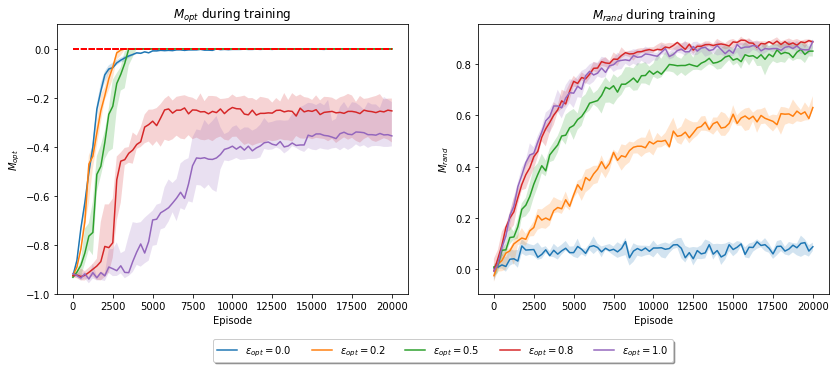

In [23]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_epsilon_opt_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_opt_list = pickle.load(handle)

plot_epsilon_opt = [0., 0.2, 0.5, 0.8, 1.]
plot_stats(stats_dict_eps_opt_list, plot_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=save_figs, keys=['test_Mopt', 'test_Mrand'], perc=True)

##### Plot for all the experimented values

epsilon_opt = 0.0 : 	M_opt =  0.0 	M_rand =  0.101
epsilon_opt = 0.1 : 	M_opt =  0.0 	M_rand =  0.442
epsilon_opt = 0.2 : 	M_opt =  0.0 	M_rand =  0.612
epsilon_opt = 0.3 : 	M_opt =  0.0 	M_rand =  0.762
epsilon_opt = 0.4 : 	M_opt =  0.0 	M_rand =  0.8
epsilon_opt = 0.5 : 	M_opt =  0.0 	M_rand =  0.849
epsilon_opt = 0.6 : 	M_opt =  0.0 	M_rand =  0.873
epsilon_opt = 0.7 : 	M_opt =  -0.043 	M_rand =  0.892
epsilon_opt = 0.8 : 	M_opt =  -0.253 	M_rand =  0.874
epsilon_opt = 0.9 : 	M_opt =  -0.276 	M_rand =  0.895
epsilon_opt = 1.0 : 	M_opt =  -0.348 	M_rand =  0.877


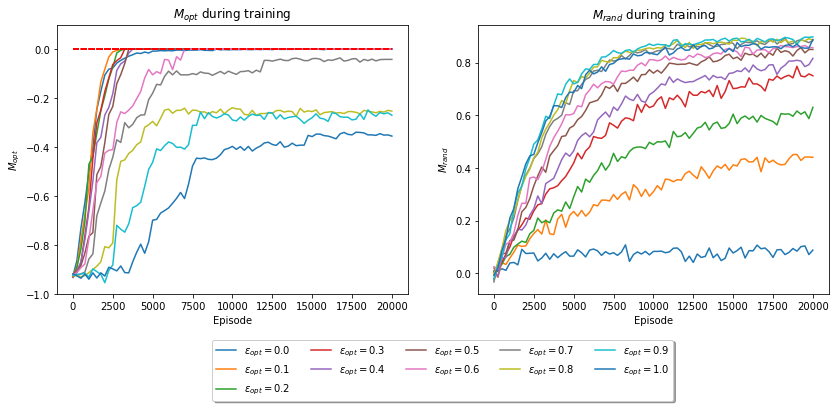

In [21]:
plot_stats(stats_dict_eps_opt_list, vec_epsilon_opt, "epsilon_opt", "\epsilon_{opt}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 5: Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
np.random.seed(seed)
random.seed(seed)
# Setting hyperparams
n_star = 1
epsilon_min = 0.1
epsilon_max = 0.8
# Training
Q, stats = q_learning(env, num_episodes=20000, epsilon_exploration_rule=return_lambda_explor(epsilon_min, epsilon_max, n_star), verbose=False, epsilon_opt=0.5, against_opt=True)
# Measuring performance
m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
print("M_opt = ", m_opt)
m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
print("M_rand = ", m_rand)

### 2.2 Learning by self-practice

#### Question 7: Self-learning with constant rate of exploration $\epsilon$

In [17]:
epsilon_vec = np.round(np.linspace(0,0.9,10), decimals=1)
print(epsilon_vec)
var_name = 'eps_self'
q_learning_params_list = []
for eps in epsilon_vec:
    params = {'env': env,
              'verbose': True,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True}
    q_learning_params_list.append(params)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [ ]:
if train:
    stats_dict_eps_self_list = train_avg(var_name, epsilon_vec, q_learning_params_list, num_avg=1, save_stats=False)

epsilon_self = 0 : 	M_opt =  -0.843 	M_rand =  0.18
epsilon_self = 0.2 : 	M_opt =  -0.239 	M_rand =  0.77
epsilon_self = 0.5 : 	M_opt =  -0.113 	M_rand =  0.877
epsilon_self = 0.8 : 	M_opt =  -0.302 	M_rand =  0.898


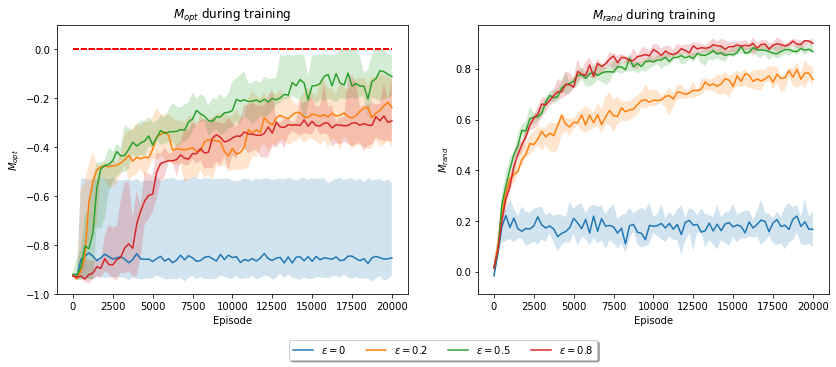

In [15]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_eps_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_eps_self_list = pickle.load(handle)

epsilon_vec_plot = [0, 0.2, 0.5, 0.8] # are these okay?
plot_stats(stats_dict_eps_self_list, epsilon_vec_plot, "epsilon_self", "\epsilon", save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

##### Plot for all the experimented values

epsilon_self = 0.0 : 	M_opt =  -0.843 	M_rand =  0.18
epsilon_self = 0.1 : 	M_opt =  -0.352 	M_rand =  0.655
epsilon_self = 0.2 : 	M_opt =  -0.239 	M_rand =  0.77
epsilon_self = 0.3 : 	M_opt =  -0.158 	M_rand =  0.834
epsilon_self = 0.4 : 	M_opt =  -0.236 	M_rand =  0.862
epsilon_self = 0.5 : 	M_opt =  -0.113 	M_rand =  0.877
epsilon_self = 0.6 : 	M_opt =  -0.20800000000000002 	M_rand =  0.905
epsilon_self = 0.7 : 	M_opt =  -0.131 	M_rand =  0.892
epsilon_self = 0.8 : 	M_opt =  -0.302 	M_rand =  0.898
epsilon_self = 0.9 : 	M_opt =  -0.285 	M_rand =  0.918


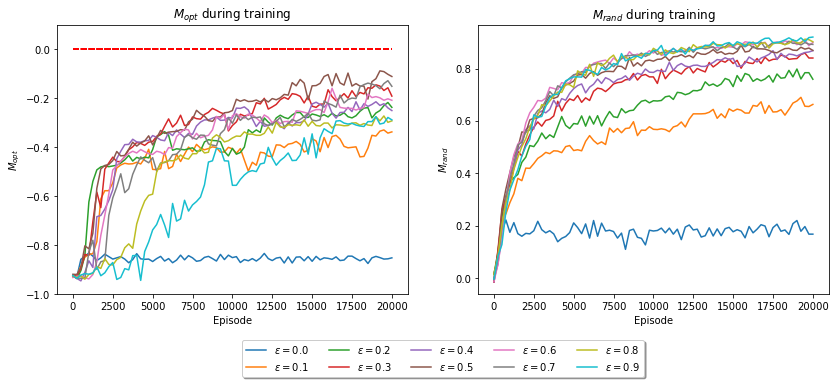

In [18]:
plot_stats(stats_dict_eps_self_list, epsilon_vec, "epsilon_self", "\epsilon", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Question 8: Decaying exploration rule for different values of $n^*$

In [29]:
epsilon_min = 0.1
epsilon_max = 0.8
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
num_splits = 2
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)
qlearning_params_list = []
print('alpha = ', alpha)
for (idx, chunk) in enumerate(chunks_list):
    qlearning_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
                  'num_episodes': num_episodes,
                  'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
                  'test_freq': test_freq,
                  'alpha': alpha,
                  'self_practice': True}
        qlearning_params_list[idx].append(params)

In [ ]:
chunk_num = 1
np.random.seed(seed)
random.seed(seed)
if train:
    var_name = 'q_learning_n_star_self_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_nstar = train_avg(var_name, chunk, qlearning_params_list[chunk_num], num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_q_learning_n_star_self_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_nstar_list.append(to_append)
    fname = output_folder + '/stats_dict_q_learning_n_star_self_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_star_self = 1.0 : 	M_opt =  -0.331 	M_rand =  0.6839999999999999
n_star_self = 9146.0 : 	M_opt =  -0.11 	M_rand =  0.838
n_star_self = 24460.0 : 	M_opt =  -0.07100000000000001 	M_rand =  0.871
n_star_self = 40000.0 : 	M_opt =  -0.118 	M_rand =  0.914


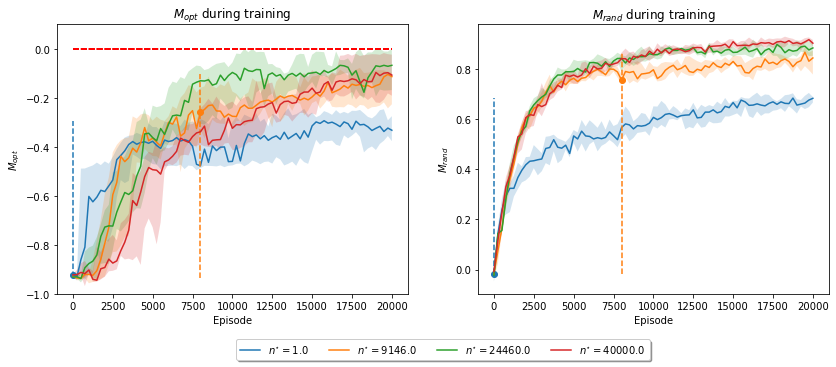

In [32]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_q_learning_n_star_self_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 9146., 24460., 40000.]
plot_stats(stats_dict_nstar_list, plot_n_star, 'n_star_self', "n^{\star}", decaying_exploration=True, save=save_figs, perc=True, keys=['test_Mopt', 'test_Mrand'])

##### Plot for all the experimented values

n_star_self = 1.0 : 	M_opt =  -0.331 	M_rand =  0.6839999999999999
n_star_self = 100.0 : 	M_opt =  -0.313 	M_rand =  0.668
n_star_self = 500.0 : 	M_opt =  -0.28500000000000003 	M_rand =  0.649
n_star_self = 750.0 : 	M_opt =  -0.355 	M_rand =  0.644
n_star_self = 1000.0 : 	M_opt =  -0.257 	M_rand =  0.688
n_star_self = 1279.0 : 	M_opt =  -0.258 	M_rand =  0.705
n_star_self = 1635.0 : 	M_opt =  -0.275 	M_rand =  0.692
n_star_self = 2091.0 : 	M_opt =  -0.29 	M_rand =  0.685
n_star_self = 2674.0 : 	M_opt =  -0.29600000000000004 	M_rand =  0.702
n_star_self = 3420.0 : 	M_opt =  -0.32 	M_rand =  0.709
n_star_self = 4373.0 : 	M_opt =  -0.279 	M_rand =  0.74
n_star_self = 5593.0 : 	M_opt =  -0.239 	M_rand =  0.753
n_star_self = 7152.0 : 	M_opt =  -0.183 	M_rand =  0.806
n_star_self = 9146.0 : 	M_opt =  -0.11 	M_rand =  0.838
n_star_self = 11696.0 : 	M_opt =  -0.16599999999999998 	M_rand =  0.811
n_star_self = 14957.0 : 	M_opt =  -0.14 	M_rand =  0.843
n_star_self = 19127.0 : 	M_opt =  -0.201 	

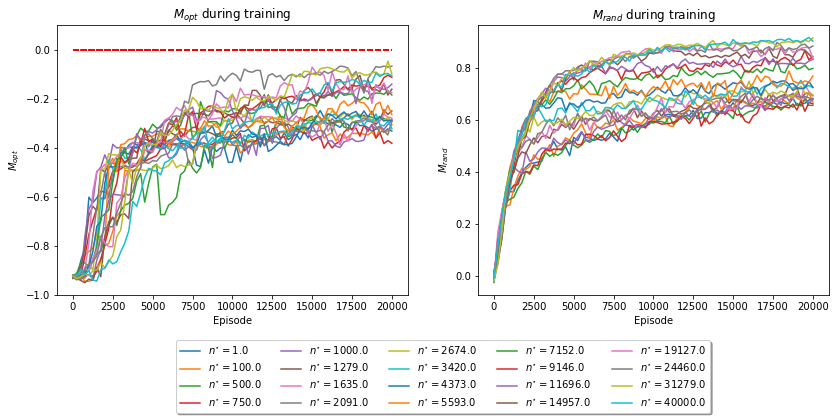

In [33]:
plot_stats(stats_dict_nstar_list, vec_n_star, 'n_star_self', "n^{\star}", save=False, keys=['test_Mopt', 'test_Mrand'])

#### Optimal values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [34]:
np.random.seed(seed)
random.seed(seed)
# Setting hyperparams
n_star = 24460
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
m_opt_vec = []
m_rand_vec = []
for i in range(10):
    Q, stats = q_learning(env, epsilon_exploration_rule = epsilon_exploration_rule, self_practice=True)
    # Measuring performance
    m_opt = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=0.))
    m_rand = measure_performance(QPlayer(Q=Q), OptimalPlayer(epsilon=1.))
    m_opt_vec.append(m_opt)
    m_rand_vec.append(m_rand)
    print("Run", i+1, ": M_opt = ", np.round(m_opt, decimals=3), "\t M_rand = ", np.round(m_rand, decimals=3))

print('*********************', ' AVERAGE STATS ', '*********************')
print("Median:\tM_opt = ", np.round(np.median(m_opt_vec),decimals=3), "\t M_rand = ", np.round(np.median(m_rand_vec),decimals=3))
print("25th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=25),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=25),decimals=3))
print("75th quantile:\tM_opt = ", np.round(np.percentile(m_opt_vec, q=75),decimals=3), "\t M_rand = ", np.round(np.percentile(m_rand_vec, q=75),decimals=3))

Run 1 : M_opt =  0.0 	 M_rand =  0.774
Run 2 : M_opt =  0.0 	 M_rand =  0.884
Run 3 : M_opt =  -0.282 	 M_rand =  0.84
Run 4 : M_opt =  -0.664 	 M_rand =  0.822
Run 5 : M_opt =  -0.274 	 M_rand =  0.88
Run 6 : M_opt =  -0.188 	 M_rand =  0.866
Run 7 : M_opt =  0.0 	 M_rand =  0.928
Run 8 : M_opt =  -0.04 	 M_rand =  0.868
Run 9 : M_opt =  0.0 	 M_rand =  0.922
Run 10 : M_opt =  -0.102 	 M_rand =  0.89
*********************  AVERAGE STATS  *********************
Median:	M_opt =  -0.071 	 M_rand =  0.874
25th quantile:	M_opt =  -0.252 	 M_rand =  0.846
75th quantile:	M_opt =  0.0 	 M_rand =  0.889


#### Question 10: Heatmaps of the Q-values in 3 significant states

In [54]:
# Optimal params
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 24460
# Training
np.random.seed(seed)
random.seed(seed)
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
Q, stats = q_learning(env, alpha=0.05, epsilon_exploration_rule=epsilon_exploration_rule, self_practice=True)

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


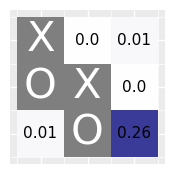

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


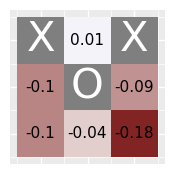

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 6 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 3 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


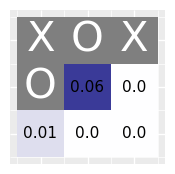

C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 5 rows containing missing values.
C:\Users\ivanb\anaconda3\envs\CS456\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


In [58]:
grids = [[1., 0., 0., -1., 1., 0., 0., -1., 0.], [1., 0., 1., 0., -1., 0., 0., 0., 0.],[1., -1., 1., -1., 0., 0., 0., 0., 0.]]
grid_numpy = []
for i in range(len(grids)):
    grid_numpy.append(np.array(grids[i]).reshape(3,3))
heatmaps_subplots(grid_numpy, Q, save=save_figs)

## Deep Q-Learning